# **Prediksi Nilai NO2 Satu Hari Kedepan dengan KNN Regression**

**Tujuan**: Memprediksi nilai NO₂ satu hari ke depan menggunakan KNN Regression, lalu menerapkan threshold untuk klasifikasi status

**Lokasi** Mencangkup :
- Kota Surabaya
- Sebagian wilayah Kabupaten Sidoarjo
- Sebagian Kabupaten Gresik

**Data Source**: Sentinel-5P (Copernicus Data Space)

**Metode**:
- KNN Regression untuk prediksi nilai kontinyu
- Threshold Application untuk klasifikasi (Aman/Berbahaya)

**Periode**:
- During COVID: **2020-06-01 s.d. 2021-06-30**
- Post COVID: **2022-06-01 s.d. 2023-06-30**

## **1. Mengumpulkan data dan dijadikan CSV**

In [3]:
import openeo
import xarray as xr
import matplotlib.pyplot as plt

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

spatial_extent = {
    "west": 112.5,
    "south": -7.45,
    "east": 112.95,
    "north": -7.05
}

# During COVID
s5covid = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2020-06-01", "2021-06-30"],
    spatial_extent=spatial_extent,
    bands=["NO2"], 
).aggregate_temporal_period(reducer="mean", period="day")

# Post COVID
s5post = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2022-06-01", "2023-06-30"],
    spatial_extent=spatial_extent,
    bands=["NO2"],  
).aggregate_temporal_period(reducer="mean", period="day")

job_covid = s5covid.execute_batch(title="NO2 during Covid", outputfile="during_covid.nc")
job_post = s5post.execute_batch(title="NO2 Post-Covid", outputfile="post_covid.nc")

Authenticated using refresh token.
0:00:00 Job 'j-25102415254144aaa53e7143b5cdf76c': send 'start'
0:00:14 Job 'j-25102415254144aaa53e7143b5cdf76c': created (progress 0%)
0:00:19 Job 'j-25102415254144aaa53e7143b5cdf76c': created (progress 0%)
0:00:26 Job 'j-25102415254144aaa53e7143b5cdf76c': created (progress 0%)
0:00:34 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:00:44 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:00:57 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:01:13 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:01:32 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:01:56 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:02:27 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:03:06 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:03:53 Job 'j-25102415254144aaa53e7143b5cdf76c': running (progress N/A)
0:04:52 Job 'j-25102415254144

In [5]:
# --- DOWNLOAD HASIL DARI SERVER ---
results_covid = job_covid.get_results()
results_post = job_post.get_results()

results_covid.download_files(target="results_covid")
results_post.download_files(target="results_post")

# --- KONVERSI KE CSV ---
import xarray as xr
import pandas as pd

# Load data dari NetCDF
during = xr.open_dataset("during_covid.nc")
post = xr.open_dataset("post_covid.nc")

# Ambil rata-rata spasial (x dan y) biar jadi satu nilai NO2 per waktu
during_mean = during.NO2.mean(dim=["x", "y"]).to_dataframe().reset_index()
post_mean = post.NO2.mean(dim=["x", "y"]).to_dataframe().reset_index()

# Simpan hasil ke CSV
during_mean.to_csv("no2_during_covid.csv", index=False)
post_mean.to_csv("no2_post_covid.csv", index=False)

print("✅ Data berhasil disimpan sebagai CSV:")
print("- no2_during_covid.csv")
print("- no2_post_covid.csv")

✅ Data berhasil disimpan sebagai CSV:
- no2_during_covid.csv
- no2_post_covid.csv


## **2.Memprosessing data jika ada missing values  dengan interpolasi**
Mengisi missing values dengan interpolasi waktu (time-based interpolation) agar datanya tetap konsisten untuk analisis.

In [9]:
import pandas as pd

# Load data hasil tahap 1
during_mean = pd.read_csv("no2_during_covid.csv")
post_mean = pd.read_csv("no2_post_covid.csv")

print("📊 HASIL PEMROSESAN DATA NO₂\n")

# 🔍 Cek missing values sebelum interpolasi
missing_during_before = during_mean.isna().sum()
missing_post_before = post_mean.isna().sum()

print("🔍 Missing Values Sebelum Interpolasi:")
print(f"- During COVID:\n{missing_during_before}")
print(f"- Post COVID:\n{missing_post_before}\n")

# --- Pastikan kolom waktu dikenali sebagai datetime dan dijadikan index ---
for df in [during_mean, post_mean]:
    if 't' in df.columns:  # kalau nama kolom waktu 't'
        df.rename(columns={'t': 'time'}, inplace=True)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)

# --- Interpolasi time-based ---
during_mean_interpolated = during_mean.interpolate(method='time')
post_mean_interpolated = post_mean.interpolate(method='time')

# Cek hasil interpolasi
missing_during_after = during_mean_interpolated.isna().sum()
missing_post_after = post_mean_interpolated.isna().sum()

print("✅ Missing Values Setelah Interpolasi:")
print(f"- During COVID:\n{missing_during_after}")
print(f"- Post COVID:\n{missing_post_after}\n")

#  Simpan hasil interpolasi ke CSV baru
during_mean_interpolated.reset_index().to_csv("no2_during_covid_clean.csv", index=False)
post_mean_interpolated.reset_index().to_csv("no2_post_covid_clean.csv", index=False)

print("💾 Data bersih sudah disimpan sebagai:")
print("- no2_during_covid_clean.csv")
print("- no2_post_covid_clean.csv\n")

# --- Buat ringkasan tabel hasil pembersihan data ---
summary = pd.DataFrame({
    "Dataset": ["During COVID", "Post COVID"],
    "Missing Sebelum": [missing_during_before['NO2'], missing_post_before['NO2']],
    "Missing Setelah": [missing_during_after['NO2'], missing_post_after['NO2']],
})

print("📋 Ringkasan Proses Interpolasi:\n")
display(summary)


📊 HASIL PEMROSESAN DATA NO₂

🔍 Missing Values Sebelum Interpolasi:
- During COVID:
t       0
NO2    78
dtype: int64
- Post COVID:
t       0
NO2    85
dtype: int64

✅ Missing Values Setelah Interpolasi:
- During COVID:
NO2    2
dtype: int64
- Post COVID:
NO2    0
dtype: int64

💾 Data bersih sudah disimpan sebagai:
- no2_during_covid_clean.csv
- no2_post_covid_clean.csv

📋 Ringkasan Proses Interpolasi:



,Dataset,Missing Sebelum,Missing Setelah
0,During COVID,78,2
1,Post COVID,85,0


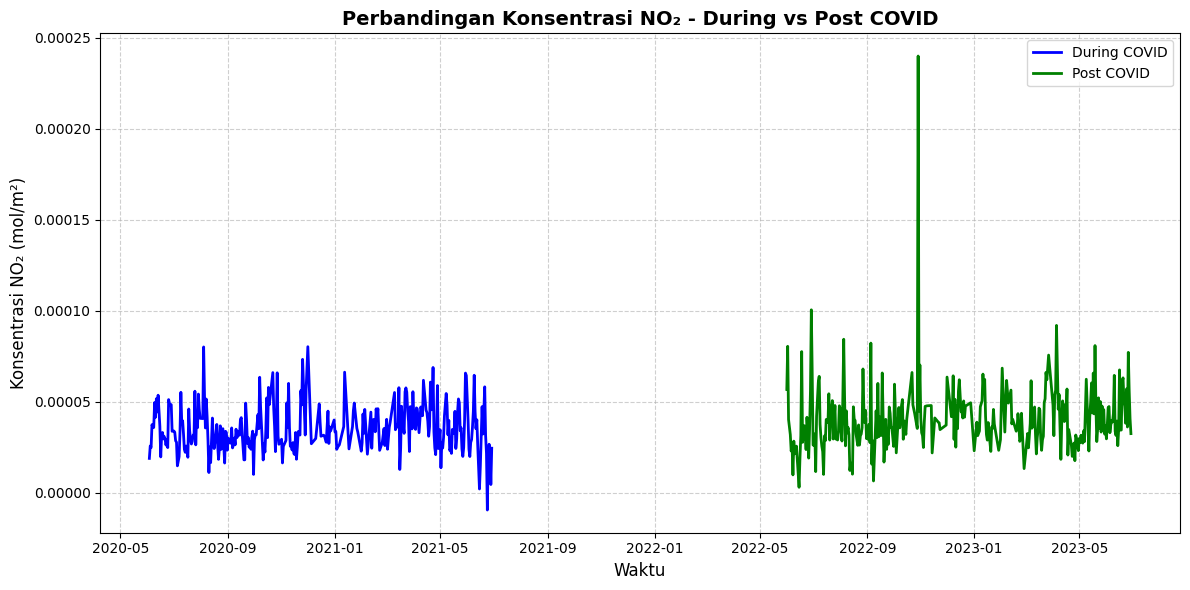

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load data bersih ---
during = pd.read_csv("no2_during_covid_clean.csv")
post = pd.read_csv("no2_post_covid_clean.csv")

# Pastikan kolom waktu terdeteksi sebagai datetime
during['time'] = pd.to_datetime(during['time'])
post['time'] = pd.to_datetime(post['time'])

# --- Buat plot ---
plt.figure(figsize=(12, 6))
plt.plot(during['time'], during['NO2'], label='During COVID', color='blue', linewidth=2)
plt.plot(post['time'], post['NO2'], label='Post COVID', color='green', linewidth=2)

# --- Tambahan estetika ---
plt.title('Perbandingan Konsentrasi NO₂ - During vs Post COVID', fontsize=14, weight='bold')
plt.xlabel('Waktu', fontsize=12)
plt.ylabel('Konsentrasi NO₂ (mol/m²)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# --- Tampilkan plot ---
plt.show()


### **Penjelasan:** 
**Perbandingan Konsentrasi NO₂ - During vs Post COVID**
- **Sumbu-X (horizontal)**: Waktu pengamatan (dalam rentang tanggal).
- **Sumbu-Y (vertikal)**: Konsentrasi NO₂ (Nitrogen Dioksida) dalam satuan mol/m².

 **Periode During COVID (garis biru) :**
- Terlihat relatif stabil dengan sedikit fluktuasi di kisaran 0.00003–0.00007 mol/m².
- Tidak ada lonjakan besar — ini menunjukkan bahwa selama pandemi (saat mobilitas menurun), polusi NO₂ cenderung rendah dan terkendali.
- Hal ini sesuai dengan banyak penelitian yang menemukan penurunan emisi akibat pembatasan aktivitas industri dan transportasi.

 **Periode Post COVID (garis hijau) :**
- Secara umum, tingkat NO₂ meningkat sedikit dibanding masa pandemi.
- Ada satu lonjakan signifikan sekitar pertengahan 2022, kemungkinan besar akibat aktivitas industri/transportasi yang kembali normal.
- Setelah lonjakan itu, pola NO₂ cenderung lebih fluktuatif, menunjukkan aktivitas ekonomi yang sudah pulih.

 **Kesimpulan dari Grafik :**
- Secara visual, **selama pandemi** terjadi **penurunan konsentrasi NO₂** yang cukup konsisten.
- **Setelah pandemi**, terjadi **kenaikan dan variabilitas lebih besar**. Artinya aktivitas emisi kembali meningkat.
- Grafik ini mendukung analisis dampak kebijakan pembatasan sosial terhadap kualitas udara.